In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [2]:
import os
os.environ["LD_LIBRARY_PATH"]

':/home/grinenko/anaconda3/envs/anna/lib/'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
import json
import tensorflow as tf
import keras

2023-12-21 07:51:13.541279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
W=10

In [5]:
import Clustering

In [6]:
import Forecasting

2023-12-21 07:51:16.289406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 07:51:16.294265: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices() 

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13624624651670086338
 xla_global_id: -1]

In [ ]:
# import importlib
# import Clustering, Forecasting
# importlib.reload(Clustering)
# importlib.reload(Forecasting)

In [ ]:
# import tensorflow.compat.v1 as tf

In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [8]:
data = pd.read_csv("DataSet2.csv", sep=";")#, parse_dates=['Timestamp']) #, nrows=10)

In [9]:
columns = data.columns

In [ ]:
columns
#CV, DV

In [10]:
metafile = open("DataSet2_fix.json")
metafile = json.load(metafile)

In [11]:
CV_DV = [x[0] for x in metafile['ColumnKind'].items() if x[1] == "CV" or x[1] == "DV"]
CV_DV = [x for x in list(columns) if x in CV_DV]
# data = data[CV_DV]
CV_DV

['percent_01_LAB',
 'percent_04_LAB',
 'quality_01_LAB',
 'pressure_01_LAB',
 'consumption_04',
 'consumption_07',
 'percent_13',
 'percent_05',
 'pressure_06',
 'pressure_03',
 'pressure_08',
 'percent_12',
 'pressure_05',
 'percent_08',
 'pressure_07',
 'percent_10',
 'pressure_10',
 'pressure_02',
 'percent_02',
 'percent_09',
 'percent_06',
 'percent_07',
 'percent_11',
 'percent_03',
 'temperature_19',
 'temperature_18',
 'temperature_01_LAB',
 'temperature_21',
 'temperature_22',
 'temperature_23',
 'temperature_24',
 'consumption_01',
 'pressure_11',
 'temperature_20']

In [37]:
data.shape

(2040480, 68)

In [38]:
K = 60
df = data.groupby(data.index // K).mean() #усреднение
df_np = df.to_numpy()

In [39]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanAbsolutePercentageError
from sklearn.metrics import mean_absolute_error as mae
mase = MeanAbsoluteScaledError(multioutput='raw_values')
mase_uni = MeanAbsoluteScaledError(multioutput='uniform_average')
mape = MeanAbsolutePercentageError(multioutput='raw_values')
# mae = MeanAbsoluteError()


#if ‘raw_values’, returns a full set of errors in case of multioutput input. If ‘uniform_average’, errors of all outputs are averaged with uniform weight.

In [40]:
dataset = df_np[:, :]
# dataset = np.concatenate((dataset[:, :8], dataset[:, 9:]), axis=1)
dataset.shape

(34008, 67)

**__Отбор признаков на минималках__**

In [41]:
#удаление константных
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(0.001)
dataset1 = selector.fit_transform(dataset) 
dataset1.shape

(34008, 65)

In [42]:
set(range(dataset1.shape[-1])) - set(selector.get_feature_names_out(input_features=np.arange(dataset.shape[-1])))

{8, 14}

In [43]:
set(columns[1:]) - set(selector.get_feature_names_out(input_features=columns[1:]))

{'consumption_07', 'consumption_09'}

In [44]:
print(np.unique(dataset[:, 14]))

[0.]


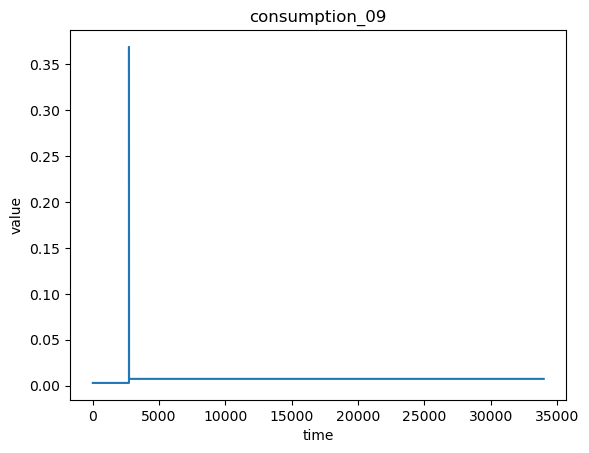

In [45]:
# plt.plot(dataset[:, 8], color="green")
plt.plot(np.concatenate((dataset[:32714, 8], dataset[32717:, 8])))
plt.title("consumption_09")
plt.xlabel("time")
plt.ylabel("value")
plt.show()

In [46]:
# values = np.unique(dataset[:, 8])
# print(values)
# print([len(np.argwhere(dataset[:, 8] == val)) for val in values])
# print(f"Изменение только в {np.argwhere(dataset[1:, 8] - dataset[:-1, 8])}")

**Эти датчики пока выкинем из-за константности: ** 

8: consumption_09

14 : consumption_07 


In [47]:
columns[15], columns[9]

('consumption_07', 'consumption_09')

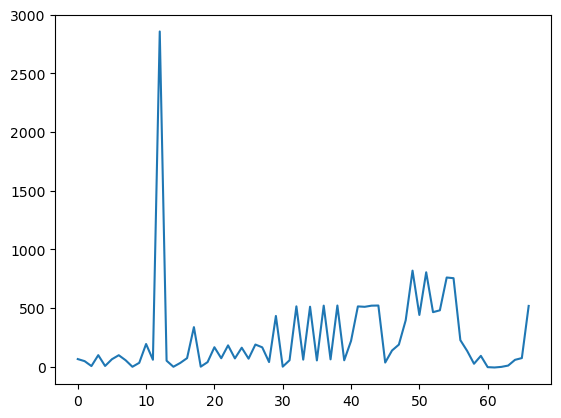

In [48]:
plt.plot(dataset[7])    

In [49]:
# from scipy.signal import correlate
# a = np.array([np.sin(x + 1) for x in range(10)])
# b = np.array([np.sin(x + 2) for x in range(10)])
# c = correlate(a, b, mode="full") #mode='same'
# plt.plot(a, label="a")
# plt.plot(b, label="b")
# plt.plot(c, label="correlation")
# plt.legend()
# c.shape

In [50]:
dataset = dataset1
dataset.shape

(34008, 65)

**Прогнозирование**

In [51]:
dataset = dataset1[:]
dataset.shape

(34008, 65)

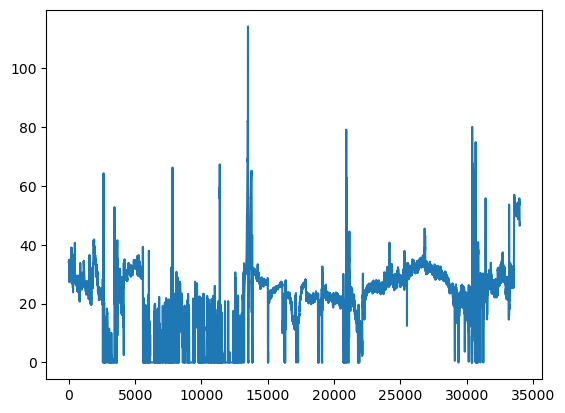

In [52]:
plt.plot(dataset[..., 8])

In [53]:
from sklearn.model_selection import train_test_split
window_sizes_for_clustering = 10
# X, y = dataset[:-window_sizes_for_clustering, ...], dataset[window_sizes_for_clustering:, ...]
# X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
n_split = round(0.2 * dataset.shape[0])
dataset_train, dataset_test = dataset[:-n_split, ...], dataset[-n_split:, ...]

In [54]:
#кластеризация для всех
dataset_train = dataset[:]

In [55]:
dataset_train.shape, dataset_test.shape

((34008, 65), (6802, 65))

In [60]:
window_sizes_for_clustering = [5] # [1, 5, 10] #[1, 3, 5, 10, 15]
Ns_clusters = [11] #[2, 7, 9, 11] #[2, 9, 11] #, 3 5, 7]#[2, 5, 7, 9, 11, 13]
# k=30, mean_dist=39 (1600)
# k=60, md = 51 (1600)
# k=20, md=33 (1000)
# k=10, md=23 (896)
# k_eps = [(10, 23), (20, 33), (60, 51), (30, 39)] #for average60 mean(dist_for_k_neighbours)

In [57]:
# k_eps = [(10, 46), (20, 66), (30, 78), (60, 102), (60, 61)]
k_eps = [(3, 0.33), (13, 0.95), (25, 1.4), (35, 1.6), (67, 2), (100, 2.3), (110, 2.4), (120, 2.5)]
k_eps = [(x, y * k) for x, y in k_eps for k in [1, 1.2, 1.5, 1.8, 2]]

In [58]:
k_eps

[(3, 0.33),
 (3, 0.396),
 (3, 0.495),
 (3, 0.5940000000000001),
 (3, 0.66),
 (13, 0.95),
 (13, 1.14),
 (13, 1.4249999999999998),
 (13, 1.71),
 (13, 1.9),
 (25, 1.4),
 (25, 1.68),
 (25, 2.0999999999999996),
 (25, 2.52),
 (25, 2.8),
 (35, 1.6),
 (35, 1.92),
 (35, 2.4000000000000004),
 (35, 2.8800000000000003),
 (35, 3.2),
 (67, 2),
 (67, 2.4),
 (67, 3.0),
 (67, 3.6),
 (67, 4),
 (100, 2.3),
 (100, 2.76),
 (100, 3.4499999999999997),
 (100, 4.14),
 (100, 4.6),
 (110, 2.4),
 (110, 2.88),
 (110, 3.5999999999999996),
 (110, 4.32),
 (110, 4.8),
 (120, 2.5),
 (120, 3.0),
 (120, 3.75),
 (120, 4.5),
 (120, 5.0)]

In [34]:
# clustering_algorithms += [Clustering.DBSCAN_for_windows(W=W, eps=eps*delta, min_samples=k) for W in window_sizes_for_clustering for k, eps in k_eps for delta in [0.8, 1, 1.2, 2]]

In [61]:
clusters_algorithms = ["Agglomerative"] #["Agglomerative"] #["MeanShift"]
clustering_algorithms = []
# clustering_algorithms += [Clustering.Kmeans_for_windows(W=W, N_clusters=N_cluster) for W in window_sizes_for_clustering for N_cluster in Ns_clusters]
# clustering_algorithms += [Clustering.MeanShift_for_windows(W=W) for W in window_sizes_for_clustering]
clustering_algorithms += [Clustering.AgglomerativeClustering_for_windows(W=W, N_clusters=N_cluster) for W in window_sizes_for_clustering for N_cluster in Ns_clusters]
# clustering_algorithms += [Clustering.DBSCAN_for_windows(W=W, eps=eps, min_samples=k) for W in window_sizes_for_clustering for k, eps in k_eps]

Clusterization __init__: W=5, <class 'int'>


In [62]:
cluster_algs = []
# cluster_algs += [('Kmeans', W, N_cluster) for W in window_sizes_for_clustering for N_cluster in Ns_clusters]
# cluster_algs += [('MeanShift', W, 0)  for W in window_sizes_for_clustering]
cluster_algs += [('Agglomer', W,  N_cluster) for W in window_sizes_for_clustering for N_cluster in Ns_clusters]
# cluster_algs += [('DBSCAN', W, k, eps) for W in window_sizes_for_clustering for k, eps in k_eps]

In [63]:
# N, M, Q = 100, 100, 2
# dataset_train = np.column_stack([[np.sin(x / 40) for x in range(N)], [0.01 + np.sin(x / 20) for x in range(N)]])
# # dataset_train = np.array([np.sin(x / 10000) for x in range(N)])[:, None]
# # dataset_train = np.column_stack(([np.sqrt(x / 10) for x in range(N)], [x + ])
# dataset_test = np.column_stack([[np.sin(x / 30) for x in range(M)], [0.01 + np.sin(x / 30)*1.01 for x in range(M)]])

In [64]:
dataset_train.shape

(34008, 65)

In [65]:
#clusters_labels, clusters_model 
# clustering_results = [Clustering.apply_clustering(dataset, cur_cluster_alg) for cur_cluster_alg in clustering_algorithms]
# clusters_labels = [x[0] for x in clustering_results]
# clusters_models = [x[1] for x in clustering_results]
clustering_results = [cur_cluster_alg.fit_predict(dataset_train) for cur_cluster_alg in clustering_algorithms]
clusters_labels = clustering_results

AgglomerativeClustering_for_windows: (34008, 65)
Done


In [ ]:
tmp = []
# отбор для DBSCAN
for i, cl_re in enumerate(clusters_labels):
    un, cnt = np.unique(cl_re, return_counts=True)
    if clustering_algorithms[i].n_normal_clusters != un.shape[0]:
        tmp.append(cnt[-1] / np.sum(cnt[:-1]))
    else:
        tmp.append(0)
plt.plot(np.sort(tmp))

In [ ]:
# отбор для DBSCAN
inds = []
for i, cl_re in enumerate(clusters_labels):
    un, cnt = np.unique(cl_re, return_counts=True)
    if clustering_algorithms[i].n_normal_clusters != un.shape[0]:
        if cnt[-1] >= np.sum(cnt[:-1]) * 0.3 or np.argmax(cnt) == len(cnt) - 1:
            continue
    print(i, clustering_algorithms[i].eps, clustering_algorithms[i].min_samples, cnt[-1] / np.sum(cnt[:-1]))
    inds.append(i)

In [66]:
clustering_algorithms = [clustering_algorithms[x] for x in inds]
cluster_algs = [cluster_algs[x] for x in inds]

NameError: name 'inds' is not defined

In [ ]:
clusters_labels = [clusters_labels[x] for x in inds]

In [ ]:
cluster_algs

In [ ]:
plt.hist(clustering_results[0])

In [67]:
W=20

In [68]:
# models, results_training 
# forecasting_training_results = [Forecasting.apply_forecasting_training(dataset, cur_cluster_labels, W=10) for cur_cluster_labels in clusters_labels]
# models = [x[0] for x in forecasting_training_results]
# results_training = [x[1] for x in forecasting_training_results]
# metrics = [x[2] for x in forecasting_training_results]
#_simple_version
forecasting_training_results = [Forecasting.apply_forecasting_training_simple_version(dataset_train, cur_cluster_labels, W=W) for cur_cluster_labels in clusters_labels]
models = [x[0] for x in forecasting_training_results]
results_training = [x[1] for x in forecasting_training_results]
metrics_training = [x[2] for x in forecasting_training_results]

N_clusters=11
dataset_windows.shape=(33987, 1, 21, 65), labels.shape=(33987,)
IN Clustering.split_to_clusters: mask.sum()=639, 639
IN Clustering.split_to_clusters: mask.sum()=7473, 7473
IN Clustering.split_to_clusters: mask.sum()=6488, 6488
IN Clustering.split_to_clusters: mask.sum()=6393, 6393
IN Clustering.split_to_clusters: mask.sum()=196, 196
IN Clustering.split_to_clusters: mask.sum()=805, 805
IN Clustering.split_to_clusters: mask.sum()=9479, 9479
IN Clustering.split_to_clusters: mask.sum()=1800, 1800
IN Clustering.split_to_clusters: mask.sum()=166, 166
IN Clustering.split_to_clusters: mask.sum()=391, 391
IN Clustering.split_to_clusters: mask.sum()=157, 157
In split_to_train_test: dataset_X.shape=(639, 20, 65), dataset_y.shape=(639, 65)


2023-12-21 07:58:27.715859: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/100
6/6 [==============================] - 1s 68ms/step - loss: 0.1509 - val_loss: 0.4404
Epoch 2/100
6/6 [==============================] - 0s 62ms/step - loss: 0.1486 - val_loss: 0.4393
Epoch 3/100
6/6 [==============================] - 0s 61ms/step - loss: 0.1465 - val_loss: 0.4383
Epoch 4/100
6/6 [==============================] - 0s 58ms/step - loss: 0.1444 - val_loss: 0.4373
Epoch 5/100
6/6 [==============================] - 0s 53ms/step - loss: 0.1425 - val_loss: 0.4364
Epoch 6/100
6/6 [==============================] - 0s 55ms/step - loss: 0.1407 - val_loss: 0.4355
Epoch 7/100
6/6 [==============================] - 0s 62ms/step - loss: 0.1389 - val_loss: 0.4347
Epoch 8/100
6/6 [==============================] - 0s 62ms/step - loss: 0.1373 - val_loss: 0.4339
Epoch 9/100
6/6 [==============================] - 0s 61ms/step - loss: 0.1357 - val_loss: 0.4332
Epoch 10/100
6/6 [==============================] - 0s 61ms/step - loss: 0.1342 - val_loss: 0.4324
Epoch 11/100
6/6 [=

Epoch 84/100
6/6 [==============================] - 0s 53ms/step - loss: 0.0928 - val_loss: 0.4120
Epoch 85/100
6/6 [==============================] - 0s 56ms/step - loss: 0.0927 - val_loss: 0.4119
Epoch 86/100
6/6 [==============================] - 0s 54ms/step - loss: 0.0925 - val_loss: 0.4118
Epoch 87/100
6/6 [==============================] - 0s 54ms/step - loss: 0.0923 - val_loss: 0.4116
Epoch 88/100
6/6 [==============================] - 0s 53ms/step - loss: 0.0922 - val_loss: 0.4115
Epoch 89/100
6/6 [==============================] - 0s 53ms/step - loss: 0.0920 - val_loss: 0.4114
Epoch 90/100
6/6 [==============================] - 0s 53ms/step - loss: 0.0918 - val_loss: 0.4113
Epoch 91/100
6/6 [==============================] - 0s 53ms/step - loss: 0.0917 - val_loss: 0.4112
Epoch 92/100
6/6 [==============================] - 0s 53ms/step - loss: 0.0915 - val_loss: 0.4111
Epoch 93/100
6/6 [==============================] - 0s 54ms/step - loss: 0.0914 - val_loss: 0.4109
Epoch 94/1

71/71 [==============================] - 4s 50ms/step - loss: 0.2199 - val_loss: 0.2927
Epoch 65/100
71/71 [==============================] - 3s 49ms/step - loss: 0.2197 - val_loss: 0.2926
Epoch 66/100
71/71 [==============================] - 4s 49ms/step - loss: 0.2194 - val_loss: 0.2926
Epoch 67/100
71/71 [==============================] - 4s 50ms/step - loss: 0.2192 - val_loss: 0.2925
Epoch 68/100
71/71 [==============================] - 3s 49ms/step - loss: 0.2190 - val_loss: 0.2925
Epoch 69/100
71/71 [==============================] - 3s 49ms/step - loss: 0.2189 - val_loss: 0.2924
Epoch 70/100
71/71 [==============================] - 4s 55ms/step - loss: 0.2187 - val_loss: 0.2924
Epoch 71/100
71/71 [==============================] - 3s 49ms/step - loss: 0.2184 - val_loss: 0.2924
Epoch 72/100
71/71 [==============================] - 3s 48ms/step - loss: 0.2183 - val_loss: 0.2923
Epoch 73/100
71/71 [==============================] - 3s 49ms/step - loss: 0.2181 - val_loss: 0.2923
Epo

61/61 [==============================] - 3s 49ms/step - loss: 0.2614 - val_loss: 0.2726
Epoch 62/100
61/61 [==============================] - 3s 49ms/step - loss: 0.2611 - val_loss: 0.2725
Epoch 63/100
61/61 [==============================] - 3s 53ms/step - loss: 0.2609 - val_loss: 0.2723
Epoch 64/100
61/61 [==============================] - 3s 49ms/step - loss: 0.2606 - val_loss: 0.2722
Epoch 65/100
61/61 [==============================] - 3s 53ms/step - loss: 0.2604 - val_loss: 0.2720
Epoch 66/100
61/61 [==============================] - 3s 49ms/step - loss: 0.2602 - val_loss: 0.2719
Epoch 67/100
61/61 [==============================] - 3s 49ms/step - loss: 0.2600 - val_loss: 0.2717
Epoch 68/100
61/61 [==============================] - 3s 50ms/step - loss: 0.2598 - val_loss: 0.2717
Epoch 69/100
61/61 [==============================] - 3s 49ms/step - loss: 0.2596 - val_loss: 0.2715
Epoch 70/100
61/61 [==============================] - 3s 49ms/step - loss: 0.2593 - val_loss: 0.2714
Epo

60/60 [==============================] - 3s 48ms/step - loss: 0.2516 - val_loss: 0.2681
Epoch 42/100
60/60 [==============================] - 3s 50ms/step - loss: 0.2513 - val_loss: 0.2679
Epoch 43/100
60/60 [==============================] - 3s 48ms/step - loss: 0.2510 - val_loss: 0.2676
Epoch 44/100
60/60 [==============================] - 3s 52ms/step - loss: 0.2507 - val_loss: 0.2674
Epoch 45/100
60/60 [==============================] - 3s 51ms/step - loss: 0.2503 - val_loss: 0.2672
Epoch 46/100
60/60 [==============================] - 3s 48ms/step - loss: 0.2500 - val_loss: 0.2670
Epoch 47/100
60/60 [==============================] - 3s 48ms/step - loss: 0.2497 - val_loss: 0.2668
Epoch 48/100
60/60 [==============================] - 3s 49ms/step - loss: 0.2495 - val_loss: 0.2666
Epoch 49/100
60/60 [==============================] - 3s 49ms/step - loss: 0.2492 - val_loss: 0.2664
Epoch 50/100
60/60 [==============================] - 3s 51ms/step - loss: 0.2489 - val_loss: 0.2662
Epo

2/2 [==============================] - 0s 80ms/step - loss: 0.8523 - val_loss: 0.2753
Epoch 22/100
2/2 [==============================] - 0s 82ms/step - loss: 0.8515 - val_loss: 0.2751
Epoch 23/100
2/2 [==============================] - 0s 84ms/step - loss: 0.8507 - val_loss: 0.2749
Epoch 24/100
2/2 [==============================] - 0s 91ms/step - loss: 0.8498 - val_loss: 0.2748
Epoch 25/100
2/2 [==============================] - 0s 93ms/step - loss: 0.8490 - val_loss: 0.2746
Epoch 26/100
2/2 [==============================] - 0s 89ms/step - loss: 0.8482 - val_loss: 0.2745
Epoch 27/100
2/2 [==============================] - 0s 91ms/step - loss: 0.8474 - val_loss: 0.2743
Epoch 28/100
2/2 [==============================] - 0s 88ms/step - loss: 0.8465 - val_loss: 0.2742
Epoch 29/100
2/2 [==============================] - 0s 81ms/step - loss: 0.8457 - val_loss: 0.2740
Epoch 30/100
2/2 [==============================] - 0s 91ms/step - loss: 0.8450 - val_loss: 0.2739
Epoch 31/100
2/2 [=====

8/8 [==============================] - 0s 52ms/step - loss: 0.5781 - val_loss: 0.4851
Epoch 3/100
8/8 [==============================] - 0s 52ms/step - loss: 0.5739 - val_loss: 0.4832
Epoch 4/100
8/8 [==============================] - 0s 53ms/step - loss: 0.5699 - val_loss: 0.4814
Epoch 5/100
8/8 [==============================] - 0s 53ms/step - loss: 0.5663 - val_loss: 0.4797
Epoch 6/100
8/8 [==============================] - 0s 54ms/step - loss: 0.5629 - val_loss: 0.4781
Epoch 7/100
8/8 [==============================] - 0s 54ms/step - loss: 0.5597 - val_loss: 0.4765
Epoch 8/100
8/8 [==============================] - 0s 53ms/step - loss: 0.5567 - val_loss: 0.4749
Epoch 9/100
8/8 [==============================] - 0s 53ms/step - loss: 0.5538 - val_loss: 0.4733
Epoch 10/100
8/8 [==============================] - 0s 52ms/step - loss: 0.5510 - val_loss: 0.4718
Epoch 11/100
8/8 [==============================] - 0s 53ms/step - loss: 0.5484 - val_loss: 0.4703
Epoch 12/100
8/8 [============

Epoch 85/100
8/8 [==============================] - 0s 55ms/step - loss: 0.4498 - val_loss: 0.4093
Epoch 86/100
8/8 [==============================] - 0s 56ms/step - loss: 0.4491 - val_loss: 0.4089
Epoch 87/100
8/8 [==============================] - 0s 54ms/step - loss: 0.4485 - val_loss: 0.4084
Epoch 88/100
8/8 [==============================] - 0s 60ms/step - loss: 0.4478 - val_loss: 0.4080
Epoch 89/100
8/8 [==============================] - 0s 53ms/step - loss: 0.4471 - val_loss: 0.4076
Epoch 90/100
8/8 [==============================] - 0s 52ms/step - loss: 0.4465 - val_loss: 0.4072
Epoch 91/100
8/8 [==============================] - 0s 52ms/step - loss: 0.4459 - val_loss: 0.4068
Epoch 92/100
8/8 [==============================] - 0s 52ms/step - loss: 0.4453 - val_loss: 0.4064
Epoch 93/100
8/8 [==============================] - 1s 53ms/step - loss: 0.4446 - val_loss: 0.4060
Epoch 94/100
8/8 [==============================] - 0s 56ms/step - loss: 0.4441 - val_loss: 0.4056
Epoch 95/1

89/89 [==============================] - 6s 70ms/step - loss: 0.2074 - val_loss: 0.1700
Epoch 66/100
89/89 [==============================] - 7s 74ms/step - loss: 0.2072 - val_loss: 0.1699
Epoch 67/100
89/89 [==============================] - 6s 66ms/step - loss: 0.2071 - val_loss: 0.1698
Epoch 68/100
89/89 [==============================] - 6s 71ms/step - loss: 0.2069 - val_loss: 0.1698
Epoch 69/100
89/89 [==============================] - 6s 68ms/step - loss: 0.2067 - val_loss: 0.1697
Epoch 70/100
89/89 [==============================] - 6s 67ms/step - loss: 0.2066 - val_loss: 0.1697
Epoch 71/100
89/89 [==============================] - 6s 70ms/step - loss: 0.2064 - val_loss: 0.1696
Epoch 72/100
89/89 [==============================] - 6s 68ms/step - loss: 0.2063 - val_loss: 0.1695
Epoch 73/100
89/89 [==============================] - 6s 69ms/step - loss: 0.2061 - val_loss: 0.1695
Epoch 74/100
89/89 [==============================] - 7s 75ms/step - loss: 0.2059 - val_loss: 0.1694
Epo

17/17 [==============================] - 1s 76ms/step - loss: 0.1701 - val_loss: 0.1327
Epoch 47/100
17/17 [==============================] - 1s 73ms/step - loss: 0.1698 - val_loss: 0.1325
Epoch 48/100
17/17 [==============================] - 1s 70ms/step - loss: 0.1695 - val_loss: 0.1323
Epoch 49/100
17/17 [==============================] - 1s 74ms/step - loss: 0.1692 - val_loss: 0.1321
Epoch 50/100
17/17 [==============================] - 1s 64ms/step - loss: 0.1689 - val_loss: 0.1319
Epoch 51/100
17/17 [==============================] - 1s 66ms/step - loss: 0.1686 - val_loss: 0.1318
Epoch 52/100
17/17 [==============================] - 1s 77ms/step - loss: 0.1684 - val_loss: 0.1316
Epoch 53/100
17/17 [==============================] - 1s 70ms/step - loss: 0.1681 - val_loss: 0.1314
Epoch 54/100
17/17 [==============================] - 1s 65ms/step - loss: 0.1678 - val_loss: 0.1313
Epoch 55/100
17/17 [==============================] - 1s 65ms/step - loss: 0.1676 - val_loss: 0.1311
Epo

2/2 [==============================] - 0s 107ms/step - loss: 2.7544 - val_loss: 2.8903
Epoch 27/100
2/2 [==============================] - 0s 109ms/step - loss: 2.7525 - val_loss: 2.8897
Epoch 28/100
2/2 [==============================] - 0s 130ms/step - loss: 2.7507 - val_loss: 2.8890
Epoch 29/100
2/2 [==============================] - 0s 103ms/step - loss: 2.7490 - val_loss: 2.8884
Epoch 30/100
2/2 [==============================] - 0s 92ms/step - loss: 2.7472 - val_loss: 2.8878
Epoch 31/100
2/2 [==============================] - 0s 106ms/step - loss: 2.7455 - val_loss: 2.8872
Epoch 32/100
2/2 [==============================] - 0s 94ms/step - loss: 2.7439 - val_loss: 2.8865
Epoch 33/100
2/2 [==============================] - 0s 101ms/step - loss: 2.7422 - val_loss: 2.8859
Epoch 34/100
2/2 [==============================] - 0s 97ms/step - loss: 2.7406 - val_loss: 2.8853
Epoch 35/100
2/2 [==============================] - 0s 110ms/step - loss: 2.7390 - val_loss: 2.8846
Epoch 36/100
2/2

4/4 [==============================] - 0s 83ms/step - loss: 0.5175 - val_loss: 0.4639
Epoch 8/100
4/4 [==============================] - 0s 80ms/step - loss: 0.5155 - val_loss: 0.4629
Epoch 9/100
4/4 [==============================] - 0s 83ms/step - loss: 0.5136 - val_loss: 0.4619
Epoch 10/100
4/4 [==============================] - 0s 80ms/step - loss: 0.5117 - val_loss: 0.4609
Epoch 11/100
4/4 [==============================] - 0s 77ms/step - loss: 0.5100 - val_loss: 0.4600
Epoch 12/100
4/4 [==============================] - 0s 77ms/step - loss: 0.5083 - val_loss: 0.4591
Epoch 13/100
4/4 [==============================] - 0s 76ms/step - loss: 0.5067 - val_loss: 0.4582
Epoch 14/100
4/4 [==============================] - 0s 78ms/step - loss: 0.5051 - val_loss: 0.4574
Epoch 15/100
4/4 [==============================] - 0s 79ms/step - loss: 0.5036 - val_loss: 0.4566
Epoch 16/100
4/4 [==============================] - 0s 81ms/step - loss: 0.5021 - val_loss: 0.4558
Epoch 17/100
4/4 [=======

Epoch 90/100
4/4 [==============================] - 0s 82ms/step - loss: 0.4380 - val_loss: 0.4218
Epoch 91/100
4/4 [==============================] - 0s 71ms/step - loss: 0.4375 - val_loss: 0.4216
Epoch 92/100
4/4 [==============================] - 0s 71ms/step - loss: 0.4369 - val_loss: 0.4213
Epoch 93/100
4/4 [==============================] - 0s 61ms/step - loss: 0.4364 - val_loss: 0.4210
Epoch 94/100
4/4 [==============================] - 0s 77ms/step - loss: 0.4359 - val_loss: 0.4207
Epoch 95/100
4/4 [==============================] - 0s 65ms/step - loss: 0.4354 - val_loss: 0.4204
Epoch 96/100
4/4 [==============================] - 0s 65ms/step - loss: 0.4349 - val_loss: 0.4202
Epoch 97/100
4/4 [==============================] - 0s 72ms/step - loss: 0.4344 - val_loss: 0.4199
Epoch 98/100
4/4 [==============================] - 0s 72ms/step - loss: 0.4339 - val_loss: 0.4197
Epoch 99/100
4/4 [==============================] - 0s 67ms/step - loss: 0.4334 - val_loss: 0.4194
Epoch 100/

2/2 [==============================] - 0s 81ms/step - loss: 0.4945 - val_loss: 0.5480
Epoch 72/100
2/2 [==============================] - 0s 80ms/step - loss: 0.4939 - val_loss: 0.5478
Epoch 73/100
2/2 [==============================] - 0s 88ms/step - loss: 0.4933 - val_loss: 0.5475
Epoch 74/100
2/2 [==============================] - 0s 82ms/step - loss: 0.4927 - val_loss: 0.5473
Epoch 75/100
2/2 [==============================] - 0s 81ms/step - loss: 0.4920 - val_loss: 0.5470
Epoch 76/100
2/2 [==============================] - 0s 87ms/step - loss: 0.4915 - val_loss: 0.5468
Epoch 77/100
2/2 [==============================] - 0s 81ms/step - loss: 0.4909 - val_loss: 0.5465
Epoch 78/100
2/2 [==============================] - 0s 82ms/step - loss: 0.4903 - val_loss: 0.5463
Epoch 79/100
2/2 [==============================] - 0s 80ms/step - loss: 0.4897 - val_loss: 0.5460
Epoch 80/100
2/2 [==============================] - 0s 81ms/step - loss: 0.4891 - val_loss: 0.5458
Epoch 81/100
2/2 [=====

In [ ]:
# without clustering
cur_cluster_labels = np.zeros(dataset_train.shape[0])
forecasting_training_results = [Forecasting.apply_forecasting_training_simple_version(dataset_train, cur_cluster_labels, W=W)]
models = [x[0] for x in forecasting_training_results]
results_training = [x[1] for x in forecasting_training_results]
metrics_training = [x[2] for x in forecasting_training_results]

In [ ]:
# results_training = results_training[0]

In [69]:
assert(len(models) == len(results_training))

In [70]:
Q = dataset.shape[-1]

In [71]:
len(results_training)

1

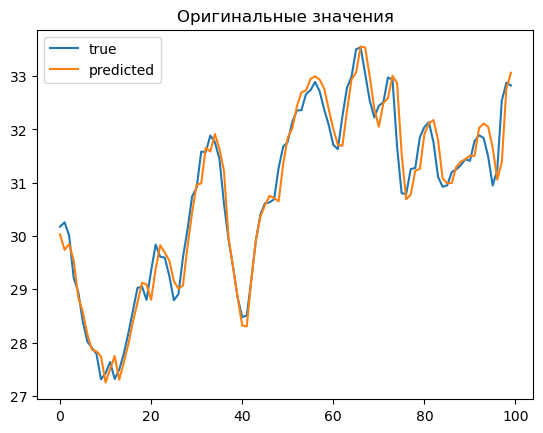

In [72]:
plt.plot(results_training[0][:100, 8], label="true")
plt.plot(results_training[0][:100, Q+8], label="predicted")
plt.legend()
plt.title("Оригинальные значения")
plt.show()

In [ ]:
# import csv
# # full_results = np.concatenate((results_training, results_testing), axis=0)
# # full_results = results_training
# full_results = np.concatenate([results_training[:, :2*Q], results_training[:, 4*Q:]], axis=1)
# with open("output_table_03-24.csv", "w") as fout:
#     writer = csv.writer(fout)
#     writer.writerow(["real "+str(i) for i in range(Q)] + ["predicted " + str(i) for i in range(Q)] + ["cluster_num", "mode"])
#     for i in range(full_results.shape[0]):
#         writer.writerow(full_results[i])


In [76]:
# print("weighted mae:", [x[-1] for x in forecasting_training_results])
print(np.mean([x['mae'] for x in metrics_training[0]], axis=1))
print(np.mean([x['mase'] for x in metrics_training[0]], axis=1))
# plt.plot([x['mae'] for x in metrics_training[0]][0])

[ 1.14789836  0.92820034  0.83646022  0.90411633  2.31104929  2.07166969
  0.66554977  0.83961822 10.37241857  1.15218634  1.45496226]
[1.25343855e+13 7.44237323e-01 7.34364024e-01 7.33748805e-01
 8.92456375e-01 1.34716077e+12 7.11910908e-01 7.87867112e-01
 8.50664930e-01 1.16863204e+00 1.45440359e+14]


In [77]:
clusters_sizes = [[np.sum(cur_clusters_labels == i) for i in range(len(np.unique(cur_clusters_labels)))] for cur_clusters_labels in clusters_labels]
N_clusters = len(clusters_sizes)
mae_on_max_cluster = np.array([metrics_training[i][np.argmax(clusters_sizes[i])]['mae'] for i in range(len(forecasting_training_results))])


In [78]:
# maes = np.array([[metrics_training[i][c]['mae'] for c in range(N_clusters)] for i in range(len(metrics_training))])
# # weighted_mae = np.array([np.average(maes[i, :, :], weights=clusters_sizes[i], axis=0) for i in range(len(forecasting_training_results))])


In [79]:
np.mean(mae_on_max_cluster, axis=1)

array([0.66554977])

In [80]:
len(models[0])

11

In [81]:
results_testing = [Forecasting.predict_through_clusters(dataset_test, clustering_algorithms[i], models[i], W=W) for i in range(len(results_training))]

N_clusters=11
dataset_windows.shape=(6782, 1, 21, 65), labels.shape=(6782,)
IN Clustering.split_to_clusters: mask.sum()=3569, 3569
IN Clustering.split_to_clusters: mask.sum()=2997, 2997
IN Clustering.split_to_clusters: mask.sum()=135, 135
IN Clustering.split_to_clusters: mask.sum()=51, 51
IN Clustering.split_to_clusters: mask.sum()=30, 30
1/1 [==============================] - 1s 588ms/step


In [82]:
len(results_testing)

1

In [83]:
[str(x) for x in clustering_algorithms]

['AgglomerativeClustering_for_windows']

Выбор алгоритма

In [84]:
TRAIN_MODE, VALID_MODE, TEST_MODE, GLOBAL_TEST_MODE = [0, 1, 2, 3]

In [85]:
full_results = [np.concatenate((
                    results_training[i],
                    np.concatenate((dataset_test[W:], results_testing[i]), axis=1)
                    ),
                    axis=0
                ) for i in range(len(results_training))]

In [86]:
#tmp
# full_results = results_testing
# full_results = [np.concatenate((dataset_test[W:], results_testing[i]), axis=1) for i in range(len(results_training))]
full_results = results_training

In [87]:
# [((x[x[:, -1] == TEST_MODE]).shape, x.shape) for x in full_results]

In [88]:
# global_metrics = [Forecasting.calc_metrics_for_full_results(x) for x in full_results]
global_metrics = [Forecasting.calc_metrics_for_full_results(x[x[:, -1] == TEST_MODE]) for x in full_results]

In [89]:
len(global_metrics)

1

In [90]:
np.mean(global_metrics[0]['mase'])

0.8463797386255971

In [91]:
# global_metrics
clusters_sizes = [np.array([np.sum(x[:, -2] == i) for i in range(len(np.unique(x[:, -2])))]) for x in full_results]
N_clusters = [len(x) for x in clusters_sizes]
print(N_clusters)
# mae_on_max_cluster = np.array([global_metrics[i][np.argmax(clusters_sizes[i])]['mae'] for i in range(len(full_results))])
# mae_mean = np.array([np.mean(global_metrics[i][np.argmax(clusters_sizes[i])]['mae']) for i in range(full_results)])

[11]


In [92]:
maes = np.array([global_metrics[i]['mae'] for i in range(len(full_results))])
mases = np.array([global_metrics[i]['mase'] for i in range(len(full_results))])
mae_on_max_cluster = np.array([
        Forecasting.calc_metrics_for_full_results(
            full_results[i][full_results[i][:, -2] == np.argmax(clusters_sizes[i])]
        )['mae'] 
    for i in range(len(full_results))])
mase_on_max_cluster = np.array([
        Forecasting.calc_metrics_for_full_results(
            full_results[i][full_results[i][:, -2] == np.argmax(clusters_sizes[i])]
        )['mase'] 
    for i in range(len(full_results))])

In [93]:
# np.around(maes, decimals=3)

In [94]:
print(np.around(np.mean(mae_on_max_cluster, axis=1),decimals=3))
print(np.around(np.mean(mase_on_max_cluster, axis=1),decimals=3))

[0.666]
[0.84]


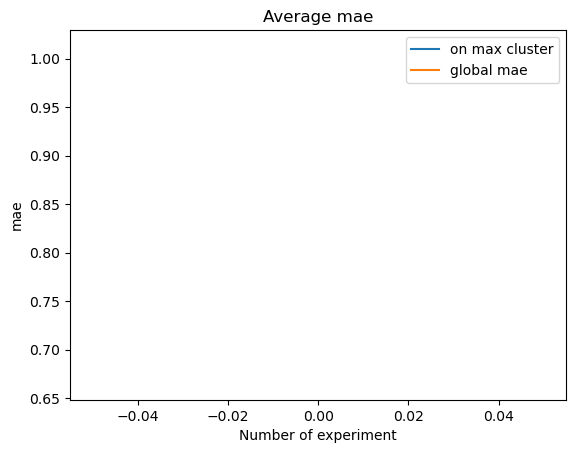

In [95]:
plt.plot(np.mean(mae_on_max_cluster, axis=1), label="on max cluster")
plt.plot(np.mean(maes, axis=1), label="global mae")
plt.legend()
plt.title("Average mae")
plt.ylabel("mae")
plt.xlabel("Number of experiment")
plt.show()

In [ ]:
plt.plot(np.mean(mase_on_max_cluster, axis=1), label="on max cluster")
plt.plot(np.mean(mases, axis=1), label="global mase")
plt.legend()
plt.title("Average mase")
plt.ylabel("mase")
plt.xlabel("Number of experiment")
plt.show()

In [ ]:
ind1 = np.argmin(np.mean(mae_on_max_cluster, axis=1))
ind1

In [ ]:
plt.hist(clusters_labels[ind1])
plt.title("Размеры кластеров")

In [ ]:
np.mean(global_metrics[ind1]['mase'])

In [ ]:
plt.plot([np.mean(x['mase']) for x in global_metrics])

In [ ]:
ind2 = np.argmin([np.mean(x['mase']) for x in global_metrics])
ind2, np.mean(global_metrics[ind2]['mase'])

In [ ]:
num = (np.abs(full_results[ind2][:, :Q] - full_results[ind2][:, Q:2*Q])).sum(axis=0) / full_results[ind2].shape[0]
denom = (np.abs(full_results[ind2][1:, :Q] - full_results[ind2][:-1, :Q])).sum(axis=0) / (full_results[ind2].shape[0] - 1)

In [ ]:
denom.mean(), num.mean()

In [ ]:
np.mean(num / denom)

Тестирование (старое)

In [ ]:
#номер сохраняемого эксперимента
IND = 0

In [ ]:
# ws = np.array([1, 1, 1, 5, 5, 5, 10, 10, 10] + [1, 1, 1, 5, 5, 5, 10, 10, 10])
ws = [1] * 5
len(ws)

In [ ]:
ns = N_clusters
ns

In [ ]:
# algs = ["Kmeans"] * 9 + ["Agglomer"] * 9
algs = ['DBSCAN'] * 5

In [ ]:
IND = 3

In [ ]:
algs = [x[0] for x in cluster_algs]
ns = N_clusters
ws = [x[1] for x in cluster_algs]
#for DBSCAN
k_s = [x[2] for x in cluster_algs]
eps_s = [x[3] for x in cluster_algs]

In [ ]:
[(algs[i], ws[i], ns[i]) for i in range(len(algs))]

In [ ]:
cluster_algs

In [ ]:
assert(len(full_results) == len(algs))

In [ ]:
import csv
# tmp = np.concatenate((dataset_test[W:], results_testing[0]), axis=1)
# full_results = np.zeros((results_training.shape[0] + results_testing.shape[0], results_training))
# full_results = np.concatenate((results_training[0], tmp), axis=0)
# full_results = results_training
# full_results = np.concatenate([results_training[:, :2*Q], results_training[:, 4*Q:]], axis=1)
for IND in range(len(full_results)):
#     with open(f"./results/W20_group60/{IND+50:02}_{algs[IND]}_N{ns[IND]}_w{ws[IND]}.csv", "w") as fout:
    with open(f"./results/W20_group30/{IND+50:02}_{algs[IND]}_N{ns[IND]}_w{ws[IND]}_k{k_s[IND]}_eps{eps_s[IND]}.csv", "w") as fout:
        writer = csv.writer(fout)
        writer.writerow(["real "+str(i) for i in range(Q)] + ["predicted " + str(i) for i in range(Q)] + ["cluster_num", "mode"])
        for i in range(full_results[IND].shape[0]):
            writer.writerow(full_results[IND][i])


In [ ]:
IND=0
with open(f"./results/W30_original.csv", "w") as fout:
    writer = csv.writer(fout)
    writer.writerow(["real "+str(i) for i in range(Q)] + ["predicted " + str(i) for i in range(Q)] + ["cluster_num", "mode"])
    for i in range(full_results[IND].shape[0]):
        writer.writerow(full_results[IND][i])

In [ ]:
data.columns

In [ ]:
read = pd.read_csv("./output_table_04-07_for60_2.csv")
new_data = pd.DataFrame(read, columns=columns)

In [ ]:
np.mean(mae_on_max_cluster, axis=1)

In [ ]:
# plt.plot(np.mean([x[-1] for x in forecasting_training_results], axis=1), label="weighted MAE")
# plt.plot(np.mean(mae_on_max_cluster, axis=1), label="MAE on max cluster")
# plt.legend()
# plt.title("MAE on different cluster algorithms")
# plt.show()

In [ ]:
clustering_results1 = [Clustering.apply_clustering(dataset, cur_cluster_alg) for cur_cluster_alg in [Clustering.MeanShift_for_windows(W=W) for W in window_sizes_for_clustering]]


In [ ]:
clusters_labels1 = [x[0] for x in clustering_results1]

clusters_sizes1 = [[np.sum(cur_clusters_labels == i) for i in range(len(np.unique(cur_clusters_labels)))] for cur_clusters_labels in clusters_labels]


In [ ]:
plt.hist(clusters_labels1[-1])
plt.yscale("log")
plt.show()

In [ ]:
np.argmin(np.mean(mae_on_max_cluster, axis=1))

In [ ]:
parameters = {"dif":True, 
              "cluster_algs":clustering_algorithms}
# models, model_mae, results_training = Forecasting.try_parameters(parameters, dataset_train)

In [ ]:
model_mae

In [ ]:
a = np.random.random((5, 4))
sc = Forecasting.MyStandardScaler()
sc.fit(a)
sc.transform(a)
sc.mean, a

Сохранение моделей

In [ ]:
IND = 14

In [ ]:
# import os
# for i, file_name in enumerate(list(os.listdir("scalers"))):
#     os.unlink("scalers/"+file_name)
# for i in range(len(models['scalers'])):
#     with open("scalers/"+str(i)+".pkl", "wb") as f:
#         pickle.dump(models['scalers'][i], f)

In [ ]:
os.unlink("clusters_model.pkl")
with open("clusters_model.pkl", "wb") as f:
#     pickle.dump(models['clusters_model'], f)
        pickle.dump(clustering_algorithms[IND], f)


In [ ]:
import os, shutil

for i, file_name in enumerate(list(os.listdir("models"))):
    shutil.rmtree("models/"+file_name)
for i in range(len(models[IND])):
    if not isinstance(models[IND][i], int):
        models[IND][i].save("models/"+str(i))
print(len(models))

Чтение моделей

In [ ]:
import os
N_clusters = len(os.listdir('models'))
assert(len(os.listdir('scalers')) == N_clusters)
models = {'models':[], 'clusters_model':[], 'scalers':[]}

In [ ]:
from tensorflow import keras
for file_name in os.listdir('models'):
    models['models'].append(keras.models.load_model('models/'+file_name))

In [ ]:
for file_name in os.listdir('scalers'):
    with open('scalers/'+file_name, 'rb') as f:
        models['scalers'].append(pickle.load(f))

In [ ]:
with open('clusters_model.pkl', 'rb') as f:
    models['clusters_model'] = pickle.load(f)

Тестирование

In [ ]:
clusters_model = models["clusters_model"]
forecasting_models = models['models']
scalers = models['scalers']
assert(len(forecasting_models) == len(scalers))

In [ ]:
import importlib
import Clustering, Forecasting
importlib.reload(Clustering)
importlib.reload(Forecasting)

In [ ]:
window_sizes_for_clustering

In [ ]:
N_clusters = 7

In [ ]:
# dataset_windows = sliding_window_view(dataset_train, (window_size_clustering, dataset_train.shape[-1])) #(N, 1, W, Q)
# new_shape = dataset_windows.shape
# dataset_windows = dataset_windows.reshape(new_shape[0], new_shape[2] * new_shape[3])
# cluster_nums = clusters_model.labels_
# print(f"{dataset.shape=}, {dataset_windows.shape=}, {cluster_nums.shape=}, {dataset.shape[0] - dataset_windows.shape[0]}")
# cluster_nums = np.pad(cluster_nums, (dataset.shape[0] - dataset_windows.shape[0], 0), mode='constant', constant_values=(cluster_nums[0])) #-1
# print(f"After pad: {dataset.shape=}, {cluster_nums.shape=}")
# # if window_size_clustering > window_size_forecasting:
# #     cluster_num = np.pad(cluster_nums, (0, ), mode='constant', constant_values=(cluster_nums[-1]))
# y_pred = np.zeros((dataset.shape[0] - window_size_forecasting, dataset.shape[-1]))
# #only if dif then +1
# dataset_windows = sliding_window_view(dataset, (window_size_forecasting + 1, dataset.shape[-1]))
# cluster_nums = cluster_nums[window_size_forecasting:] #+1
    
# full_results = np.zeros((cluster_nums.shape[0], 2 * dataset_train.shape[-1] + 2)) # real_Q, Q, cluster_num, mask

# for cluster_num in range(N_clusters):
#     mask = (cluster_nums == cluster_num)
#     if np.sum(mask) == 0:
#         continue

#     cur_windows = dataset_windows[mask, 0, ...] #(M, Wf, Q)
#     scalers[cluster_num].save_first_elements(cur_windows)
#     cur_windows = np.array(scalers[cluster_num].transform(cur_windows))
#     cur_pred = np.array(prediction_models[cluster_num](cur_windows)) #(M, Q)
#     cur_pred = scalers[cluster_num].inverse_transform(cur_pred)
#     cur_pred = scalers[cluster_num].add_first_elements(cur_pred)
#     y_pred[mask] = cur_pred
#     Q = dataset.shape[-1]
#     full_results[mask, Q:2 * Q] = cur_pred
#     full_results[mask, 2 * Q] = cluster_num
#     full_results[mask, 2 * Q + 1] = 3 #global test

In [ ]:
# window_size_for_clustering = clusters_model.cluster_centers_.shape[-1] // dataset_test.shape[-1]
window_size_for_clustering = window_sizes_for_clustering[0]
y_pred, results_testing = Forecasting.predict_through_clusters(dataset_test, clusters_model, forecasting_models, scalers, window_size_clustering=window_size_for_clustering)

In [ ]:
#лучшие параметры
window_size_for_clustering, len(forecasting_models)

In [ ]:
y_pred.shape, dataset.shape[-1]

In [ ]:
print(f"{y_pred.shape=}, {dataset_test.shape=}")
y_true = dataset_test[-y_pred.shape[0]:]
print(y_true.shape, results_testing[:, :dataset_train.shape[-1]].shape)
results_testing[:, :dataset_train.shape[-1]] = y_true
cur_mase = Forecasting.my_mase(y_true, y_pred, multioutput='raw_values')
cur_mae = Forecasting.my_mae(y_true, y_pred, multioutput="raw_values")

In [ ]:
Q = dataset_train.shape[-1]
Q

In [ ]:
import csv
# full_results = np.concatenate((results_training, results_testing), axis=0)
full_results = results_training
with open("output_table_03-23.csv", "w") as fout:
    writer = csv.writer(fout)
    writer.writerow(["real "+str(i) for i in range(Q)] + ["predicted " + str(i) for i in range(Q)] + ["cluster_num", "mode"])
    for i in range(full_results.shape[0]):
        writer.writerow(full_results[i])


In [ ]:
# cur_mase, cur_mae

In [ ]:
# full_results.shape

In [ ]:
mask = cur_mase <= np.percentile(cur_mase, 60)
plt.plot(np.arange(cur_mase.shape[0])[mask], cur_mase[mask])
plt.yscale("log")
plt.xlabel("features")
plt.ylabel("MASE")
plt.title("MASE")
plt.show()

In [ ]:
mask = cur_mae <= np.percentile(cur_mae, 60)
# plt.plot(np.arange(cur_mae.shape[0])[mask], cur_mae[mask])
plt.plot(cur_mae[mask])
plt.xlabel("features")
plt.ylabel("MAE")
plt.title("best MAE")
# plt.show()
plt.savefig("best MAE.png")

In [ ]:
plt.plot(cur_mase[cur_mase <= np.percentile(cur_mase, 100)])
plt.yscale("log")
plt.xlabel("features")
plt.ylabel("MASE")
plt.title("50% best MASE")
plt.show()

In [ ]:
cur_mape = mape(y_true, y_pred)
plt.plot(cur_mape[cur_mape < np.percentile(cur_mape, 50)])
plt.yscale("log")
plt.xlabel("features")
plt.ylabel("MAPE")
plt.title("50% best MAPE")
plt.show()

**Мелкое тестирование**

In [ ]:
N, Q = 1000, 10
# test_array = (np.random.random((N * Q)) + np.sin(np.arange(N * Q) / 100)).reshape(N, Q)
test_array = (np.sin(np.arange(N*Q)/100) * 5).reshape(N, Q)

In [ ]:
test_array

In [ ]:
W = 5
sc = Forecasting.MyStandardScaler()
clusters_X, clusters_labels = Clustering.split_to_clusters(test_array, np.zeros(test_array.shape[0]), W=W + 2)
test_array_windows = clusters_X[0]
X_true, y_true = Forecasting.split_X_y(test_array_windows)
prepared_array = sc.fit_transform(test_array_windows)
prepared_X, prepared_y = Forecasting.split_X_y(prepared_array)
y_changed = sc.inverse_transform(prepared_y)
# array_changed = sc.inverse_transform(prepared_array)

In [ ]:
plt.plot(y_true[:100, 0], label="true")
plt.plot(prepared_y[:100, 0], label="transformed")
plt.legend()
plt.show()

In [ ]:
np.max(np.abs(y_true - y_changed))

In [ ]:
test_labels = np.zeros(N)
# test_labels[test_array[:, 0] <= np.percentile(test_array, 50)] = 1

In [ ]:
test_array.shape

In [ ]:
models, test_results, _ = Forecasting.apply_forecasting_training_simple_version(test_array, test_labels)

In [ ]:
Q = test_array.shape[-1]
plt.plot(test_results[:40, 0], label="true")
plt.plot(test_results[:40, Q], label="predicted")
plt.legend()
plt.show()

In [ ]:
import csv
with open("output_table_03-22.csv", "w") as fout:
    writer = csv.writer(fout)
    writer.writerow(["real "+str(i) for i in range(Q)] + ["predicted " + str(i) for i in range(Q)] + ["cluster_num", "mode"])
    for i in range(test_results.shape[0]):
        writer.writerow(test_results[i])
